In [28]:
import os
import re
import json
from itertools import chain

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_root = 'sources'

txt = [
    {
        'path': os.path.join(data_root, x),
        'date': '2022' + x[:4]
    }
    for x in os.listdir(data_root) if 'detail' not in x]

txt = sorted(txt, key=lambda x: x['date'])

# 如果存在detail，就读取detail（3月18日开始）
for elem in txt:
    path = elem['path']
    detail_path = path.replace('.txt', '_detail.txt')
    elem['has_detail'] = False
    if os.path.exists(detail_path):
        elem['detail_path'] = detail_path
        elem['has_detail'] = True

for elem in txt:
    elem['content'] = open(elem['path']).read()
    if elem['has_detail']:
        elem['detail_content'] = open(elem['detail_path']).read()

In [3]:
block_list = [
    '浦东新区',
    '黄浦区',
    '静安区',
    '徐汇区',
    '长宁区',
    '普陀区',
    '虹口区',
    '杨浦区',
    '宝山区',
    '闵行区',
    '嘉定区',
    '金山区',
    '松江区',
    '青浦区',
    '奉贤区',
    '崇明区',
]
block_list_re = re.compile('|'.join(block_list))

In [4]:
assert block_list_re.search('浦东新区')
assert not block_list_re.search('浦东新')
assert not block_list_re.search('浦东')

In [5]:
def extract_block(s):
    """
    把下面的文本中的所在区，病例数，extract出来
    2022年3月19日，浦东新区新增8例本土确诊病例、127例本土无症状感染者，分别居住于：
    """
    m = block_list_re.search(s)
    if not m:
        return
    block = m.group(0)
    ret = {
        block: {}
    }
    m = re.search('(\d+)例本土确诊', s)
    if m:
        ret[block]['quezhen'] = int(m.group(1))
    m = re.search('(\d+)例本土无症状', s)
    if m:
        ret[block]['wuzhengzhuang'] = int(m.group(1))
    return ret

In [6]:
assert extract_block('2022年3月19日，浦东新区新增8例本土确诊病例、127例本土无症状感染者，分别居住于：')
print(extract_block('2022年3月19日，浦东新区新增8例本土确诊病例、127例本土无症状感染者，分别居住于：'))

{'浦东新区': {'quezhen': 8, 'wuzhengzhuang': 127}}


In [7]:
# 文本分解
for elem in txt:
    state = None
    state_content = {}
    if elem['has_detail']:
        lines = elem['detail_content'].split('\n')
    else:
        lines = elem['content'].split('\n')

    for line in lines:
        line = line.strip()

        if not line:
            continue

        # 删除最后的总计行
        if re.match(r'^截至\d+年\d+月\d+日.*', line):
            continue

        if line == '境外输入病例情况':
            state = 'jingwai'
        elif line == '本土无症状感染者情况':
            state = 'wuzhengzhuang'
        elif line == '本土病例情况':
            state = 'quezhen'
        # 3月18日之后，单独用detail
        elif line == '各区信息如下：':
            state = 'detail'
        elif line == '按照统一部署，今起感染者居住地信息将按区划分进行统计，小布汇总各区信息如下：':
            # 3月18日比较特殊
            state = 'detail'

        if state is not None:
            if state not in state_content:
                state_content[state] = []
            state_content[state].append(line)
        elem['state'] = state_content

In [8]:
def extract_detail(detail):
    block_detail = {}
    block = None
    addr_raw = []
    for l in detail:
        l = l.strip()
        if not l:
            continue

        if l in block_list:
            block = l
        elif block is not None:
            if block_list_re.search(l) and '新增' in l and '居住于' in l:
                block_number = extract_block(l)
                if block_number:
                    block_detail = {
                        **block_detail,
                        **block_number
                    }
            if l in block_list:
                continue
            if '无' == l:
                continue
            if '、' == l:
                continue
            if 'Reads' in l:
                continue
            if '滑动查看更多' in l:
                continue
            if '分别居住于' in l:
                continue
            if '年' in l and '新增' in l:
                continue
            if '无新增本土确诊病例' in l and '无新增本土无症状感染者' in l:
                continue
            # bad case: '崇明区资料：各区卫健委、新闻办', '崇明区编辑：吴维嘉'
            if '：' in l or ':' in l:
                continue
            # bad case: '崇明区已对相关居住地落实终末消毒措施。'
            if '已对' in l or '落实' in l or '终末' in l or '消毒' in l or '措施' in l:
                continue

            addr_raw.append(block + l)
    return addr_raw, block_detail


for elem in txt:
    addr_raw = []
    # 早期的，没有单独发布位置
    if not elem['has_detail']:
        wuzhengzhuang = elem.get('state', {}).get('wuzhengzhuang', [])
        quezhen = elem.get('state', {}).get('quezhen', [])
        block_detail = {}

        for l in quezhen:
            if '居住于' in l or '居住地为' in l:
                # '无症状感染者1，女，26岁，居住地为黄浦区瑞金二路33号，无症状感染者2，男，51岁，居住地为静安区永兴路595弄'
                # addr_raw.append(l)
                temp = map(lambda x: x[1], re.findall(r'(居住地为|居住于)([^,，$\n。]+)', l))
                temp = [x for x in temp if len(x) > 1 and x not in block_list]
                addr_raw += temp

                for a in temp:
                    for b in block_list:
                        if b in a:
                            if b not in block_detail:
                                block_detail[b] = {}
                            if 'quezhen' not in block_detail[b]:
                                block_detail[b]['quezhen'] = 0
                            block_detail[b]['quezhen'] += 1
        for l in wuzhengzhuang:
            if '居住于' in l or '居住地为' in l:
                # '无症状感染者1，女，26岁，居住地为黄浦区瑞金二路33号，无症状感染者2，男，51岁，居住地为静安区永兴路595弄'
                # addr_raw.append(l)
                temp = map(lambda x: x[1], re.findall(r'(居住地为|居住于)([^,，$\n。]+)', l))
                temp = [x for x in temp if len(x) > 1 and x not in block_list]
                addr_raw += temp

                for a in temp:
                    for b in block_list:
                        if b in a:
                            if b not in block_detail:
                                block_detail[b] = {}
                            if 'wuzhengzhuang' not in block_detail[b]:
                                block_detail[b]['wuzhengzhuang'] = 0
                            block_detail[b]['wuzhengzhuang'] += 1

        elem['addr_raw'] = addr_raw
        elem['block_detail'] = block_detail
    else:
        detail = elem.get('state', {}).get('detail', [])

        addr_raw, block_detail = extract_detail(detail)

        elem['addr_raw'] = addr_raw
        elem['block_detail'] = block_detail
        
        # 3月18日的格式和其他有些区别，所以单独抽取block_detail
        if elem['date'] == '20220318':
            qtype = None
            block_detail = {}
            lines = elem['content'].split('\n')
            for l in lines:
                l = l.strip()
                if l == '本土病例情况':
                    qtype = 'quezhen'
                elif l == '本土无症状感染者情况':
                    qtype = 'wuzhengzhuang'
                elif qtype is not None:
                    blocks = re.findall(rf'居住于({"|".join(block_list)})', l)
                    for b in blocks:
                        if b not in block_detail:
                            block_detail[b] = {}
                        if qtype not in block_detail[b]:
                            block_detail[b][qtype] = 0
                        block_detail[b][qtype] += 1
            elem['block_detail'] = block_detail

In [9]:
txt[-1]['block_detail']

{'浦东新区': {'quezhen': 307, 'wuzhengzhuang': 8743},
 '黄浦区': {'quezhen': 14, 'wuzhengzhuang': 1366},
 '静安区': {'quezhen': 22, 'wuzhengzhuang': 359},
 '徐汇区': {'quezhen': 43, 'wuzhengzhuang': 2033},
 '长宁区': {'quezhen': 29, 'wuzhengzhuang': 823},
 '普陀区': {'quezhen': 11, 'wuzhengzhuang': 946},
 '虹口区': {'quezhen': 26, 'wuzhengzhuang': 568},
 '杨浦区': {'wuzhengzhuang': 572},
 '宝山区': {'quezhen': 9, 'wuzhengzhuang': 405},
 '闵行区': {'quezhen': 95, 'wuzhengzhuang': 2162},
 '嘉定区': {'quezhen': 23, 'wuzhengzhuang': 910},
 '金山区': {'quezhen': 72, 'wuzhengzhuang': 57},
 '松江区': {'wuzhengzhuang': 644},
 '青浦区': {'quezhen': 4, 'wuzhengzhuang': 489},
 '奉贤区': {'wuzhengzhuang': 61},
 '崇明区': {'wuzhengzhuang': 260}}

In [10]:
txt[-1]['addr_raw'][:10]

['浦东新区八灶村顾家宅，',
 '浦东新区白莲泾路国展路交界口工地生活区，',
 '浦东新区白墙村，',
 '浦东新区百龙新村，',
 '浦东新区百曲村，',
 '浦东新区板泉路1201弄，',
 '浦东新区板泉路2000弄，',
 '浦东新区板泉路50号，',
 '浦东新区北艾路1077弄，',
 '浦东新区北艾路1200弄，']

In [11]:
txt[10]['addr_raw']

['徐汇区漕溪北路1200号',
 '徐汇区宜山路829号',
 '浦东新区南芦公路19弄',
 '黄浦区瑞金二路33号',
 '静安区永兴路595弄',
 '闵行区莘浜路155号',
 '闵行区龙吴路4221号',
 '徐汇区华发路406弄',
 '徐汇区宛平南路485弄',
 '浦东新区祝桥镇邓一村',
 '普陀区光新路256弄',
 '宝山区大康路1079弄',
 '普陀区宜君路80弄',
 '普陀区石泉东路168弄',
 '普陀区岚皋西路342弄',
 '普陀区石泉东路240弄',
 '宝山区宝林一村',
 '宝山区沈巷杨家宅',
 '奉贤区吴房村',
 '奉贤区吴房村',
 '宝山区聚丰园路188弄',
 '嘉定区嘉唐公路169弄',
 '闵行区普乐路333弄',
 '闵行区虹梅南路1781弄',
 '闵行区普乐路333弄',
 '闵行区普乐路333弄',
 '闵行区虹梅南路1781弄',
 '松江区泽悦路326弄',
 '松江区九亭中心路503弄',
 '松江区沪亭北路618弄',
 '松江区沪松公路2517弄',
 '浦东新区听达路325弄',
 '宝山区淞兴西路268号',
 '松江区泽悦路326弄',
 '松江区泽悦路326弄',
 '嘉定区曲江路100弄',
 '嘉定区嘉绣路955弄',
 '嘉定区红卫村',
 '嘉定区海蓝路98弄',
 '嘉定区海蓝路98弄',
 '宝山区泗塘一村',
 '嘉定区宝安公路3705弄',
 '嘉定区宝安公路3705弄',
 '嘉定区宝安公路3705弄',
 '嘉定区宝安公路3705弄',
 '嘉定区宝安公路3705弄',
 '嘉定区龙湖郦城1509弄',
 '嘉定区宝安公路3705弄']

In [12]:
txt[10]['block_detail']

{'徐汇区': {'quezhen': 2, 'wuzhengzhuang': 2},
 '浦东新区': {'quezhen': 1, 'wuzhengzhuang': 2},
 '黄浦区': {'wuzhengzhuang': 1},
 '静安区': {'wuzhengzhuang': 1},
 '闵行区': {'wuzhengzhuang': 7},
 '普陀区': {'wuzhengzhuang': 5},
 '宝山区': {'wuzhengzhuang': 6},
 '奉贤区': {'wuzhengzhuang': 2},
 '嘉定区': {'wuzhengzhuang': 13},
 '松江区': {'wuzhengzhuang': 6}}

In [13]:
df_data = []
for elem in txt:
    obj = {}
    obj['date'] = elem['date']
    for b in block_list:
        qz = elem.get('block_detail', {}).get(b, {}).get('quezhen', 0)
        wzz = elem.get('block_detail', {}).get(b, {}).get('wuzhengzhuang', 0)
        obj[b + '_quezhen'] = qz
        obj[b + '_wuzhengzhuang'] = wzz
        obj[b + '_all'] = qz + wzz
    df_data.append(obj)

In [14]:
df = pd.DataFrame(df_data)
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.to_csv('各区确诊明细.csv')

In [24]:
df.tail(3)

,浦东新区_quezhen,浦东新区_wuzhengzhuang,浦东新区_all,黄浦区_quezhen,黄浦区_wuzhengzhuang,黄浦区_all,静安区_quezhen,静安区_wuzhengzhuang,静安区_all,徐汇区_quezhen,...,松江区_all,青浦区_quezhen,青浦区_wuzhengzhuang,青浦区_all,奉贤区_quezhen,奉贤区_wuzhengzhuang,奉贤区_all,崇明区_quezhen,崇明区_wuzhengzhuang,崇明区_all
date,,,,,,,,,,,,,,,,,,,,,
2022-04-05,162,7983,8145,16,642,658,12,290,302,23,...,796,6,378,384,2,142,144,2,77,79
2022-04-06,151,8306,8457,9,1035,1044,27,518,545,19,...,781,4,466,470,0,278,278,0,63,63
2022-04-07,307,8743,9050,14,1366,1380,22,359,381,43,...,644,4,489,493,0,61,61,0,260,260


浦东新区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


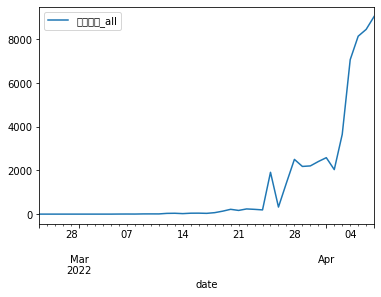

黄浦区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


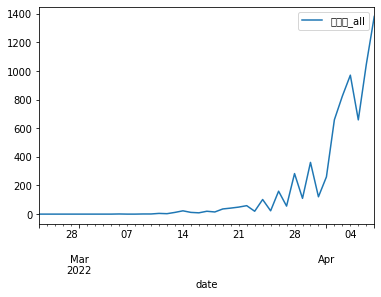

静安区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


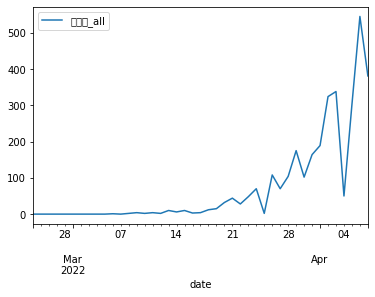

徐汇区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 24464 (\N{CJK UNIFIED IDEOGRAPH-5F90}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 27719 (\N{CJK UNIFIED IDEOGRAPH-6C47}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


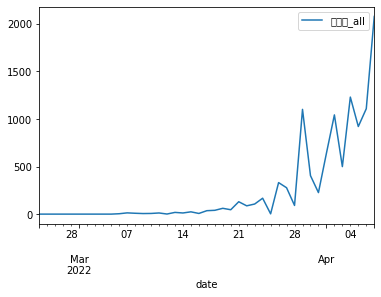

长宁区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23425 (\N{CJK UNIFIED IDEOGRAPH-5B81}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


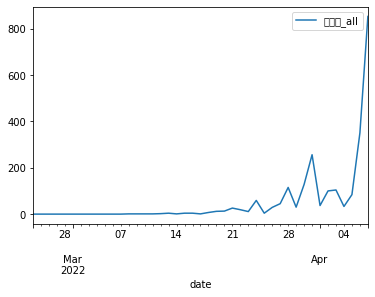

普陀区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 26222 (\N{CJK UNIFIED IDEOGRAPH-666E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38464 (\N{CJK UNIFIED IDEOGRAPH-9640}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


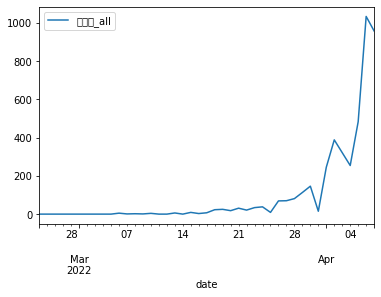

虹口区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 34425 (\N{CJK UNIFIED IDEOGRAPH-8679}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


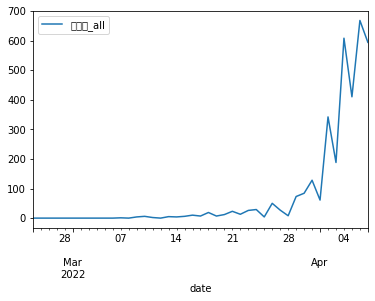

杨浦区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 26472 (\N{CJK UNIFIED IDEOGRAPH-6768}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


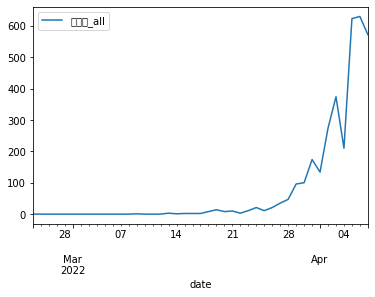

宝山区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23453 (\N{CJK UNIFIED IDEOGRAPH-5B9D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


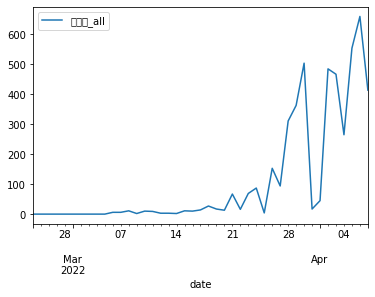

闵行区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38389 (\N{CJK UNIFIED IDEOGRAPH-95F5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


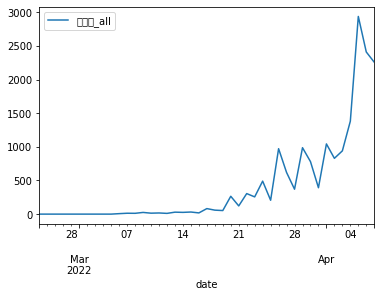

嘉定区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


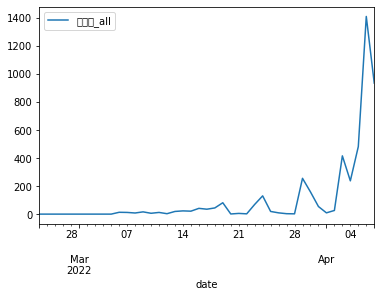

金山区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


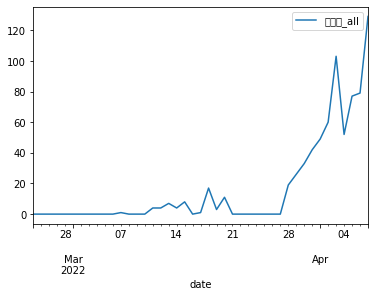

松江区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 26494 (\N{CJK UNIFIED IDEOGRAPH-677E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 27743 (\N{CJK UNIFIED IDEOGRAPH-6C5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


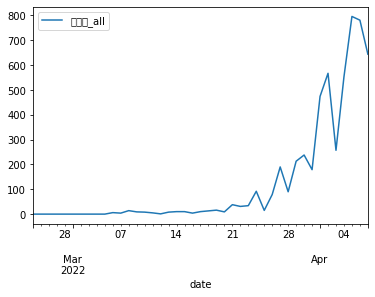

青浦区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


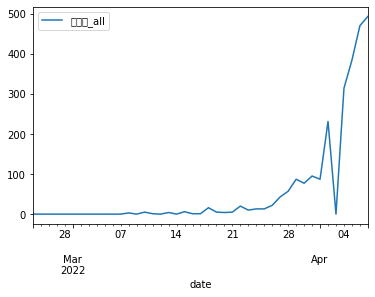

奉贤区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 22857 (\N{CJK UNIFIED IDEOGRAPH-5949}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


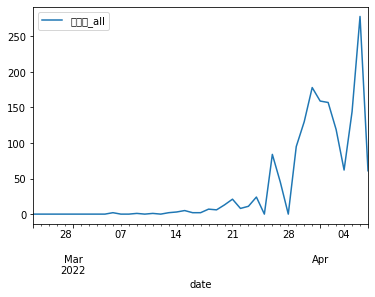

崇明区_all


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 23815 (\N{CJK UNIFIED IDEOGRAPH-5D07}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


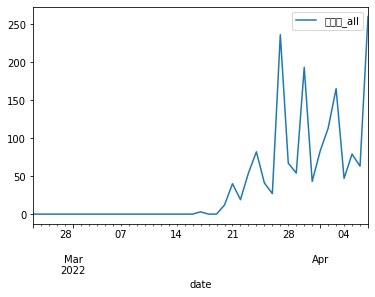

In [29]:
for c in [x for x in df.columns if '_all' in x]:
    print(c)
    df.plot(y=[c])
    plt.show()

<AxesSubplot:xlabel='date'>

/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 38389 (\N{CJK UNIFIED IDEOGRAPH-95F5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda

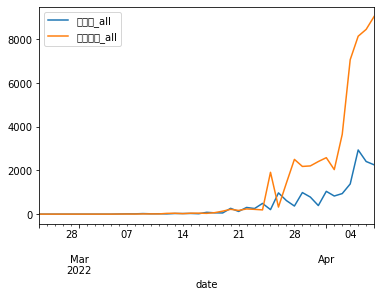

In [16]:
df.plot(y=['闵行区_all', '浦东新区_all'])

In [17]:
all_addr_flatten = []
for x in txt:
    all_addr_flatten += x['addr_raw']

all_addr_raw = [
    {
        'date': x['date'],
        'addr_raw': x['addr_raw']
    }
    for x in txt
]

In [18]:
all_addr_flatten = sorted(all_addr_flatten, key=lambda x: len(x))

In [19]:
print(all_addr_flatten[-10:])

['嘉定区江桥镇高潮七村、年丰村、田旺村、五四村、新江村、星火村、增建村，', '嘉定区安亭镇联西村、联丰村、联群村、玉兰一村、玉兰三村、安亭集贸市场，', '嘉定区徐行镇大石皮村、劳动村、钱桥村、小庙村、和桥村、红星村、徐行村。', '嘉定区江桥镇高潮村、增建村、红光村、江桥一村、江桥三村、丽江佳苑、宁兴上尚湾，', '嘉定区安亭镇联群村、星塔村、兰棠景苑、博泰景苑、玉兰一村、玉兰二村、玉兰三村。', '嘉定区徐行镇大石皮村、伏虎村、和桥村、红星村、劳动村、钱桥村、小庙村、徐行村，', '嘉定区江桥镇高潮村、红光村、江桥一村、江桥二村、五四村、先农村、星火村、增建村、莲安公寓，', '嘉定区江桥镇江桥一村、江桥二村、江桥三村、恒嘉花园、红光村、上淌湾小区、五四村、北陈家宅、水岸丽苑，', '嘉定区安亭镇顾浦村、火炬村、联群村、联西村、钱家村、安亭水产村、星明村、许家村、玉兰一村、玉兰二村、玉兰三村、赵巷村，', '嘉定区江桥镇恒嘉花园、红光村、黄家花园路杉丰公寓、火线村、嘉怡坊、建华村、江桥佳苑、年丰村、五四村、新华村、新江村、星火村、增建村，']


In [20]:
with open('addr_raw.json', 'w') as fp:
    json.dump(all_addr_raw, fp, indent=4, ensure_ascii=False)

In [21]:
!head addr_raw.json

[
    {
        "date": "20220224",
        "addr_raw": []
    },
    {
        "date": "20220225",
        "addr_raw": []
    },
    {


In [22]:
!tail addr_raw.json

            "崇明区长凯路277号，",
            "崇明区新港村，",
            "崇明区圆展路120弄，",
            "崇明区北沿公路1388号，",
            "崇明区惠中村，",
            "崇明区六滧村，",
            "崇明区八滧村。"
        ]
    }
]